# Binary art maker

In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle
import time
import cv2
from copy import deepcopy
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

In [68]:


def rescale_image(img, scale, interp_mode=None):
    """
    Rescale image either by scale (single float for x and y) or new size as a tuple (h,w)
    Uses area interpolation for downsampling and linear interpolation for upsampling of at least one dimension

    scale:
        None - keep source dimension
        float - resize with this factor
        tuple - resize to this dimension (h,w)
    """
    _h, _w = img.shape[:2]
    if isinstance(scale, float):
        w = int(_w * scale + 0.5)
        h = int(_h * scale + 0.5)
    elif scale is None:
        return img
    elif isinstance(scale, tuple) or misc.is_iterable(scale):  # be a bit forgiving of the type
        h,w = scale[:2]

    else:
        raise ValueError('Invalid scale: {}'.format(scale))

    if interp_mode is None:
        if (h > _h) or (w > _w):
            interp_mode = cv2.INTER_LINEAR  # at least one dimension upscales
        else:
            interp_mode = cv2.INTER_AREA  # downscale

    if (_h == h) and (_w == w):
        return img
    else:
        return cv2.resize(img, (w,h), interpolation=interp_mode)



def read_image_from_disc(path, grayscale=False):
    """ read and return as RGB or grayscale """
    if not grayscale:
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    return img


def to_gray(img):
     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def write_image_to_disc(img, path, max_size=None, compr=None, progressive_encoding=False):
    # switch to BGR uint8 image
    if img.dtype == np.float32:
        img_s = cv2.cvtColor(np.clip(img*255, 0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    else:
        img_s = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # resize if needed
    if max_size is not None:
        f = (np.array([min(f,1.0) for f in np.array(max_size) / img_s.shape[:2]])).min()
        img_s = rescale_image(img_s, f)

    # save image
    suffix = Path(path).suffix
    if suffix == '.png':
        compr = 10 if compr is None else compr
        params = [int(cv2.IMWRITE_PNG_COMPRESSION), compr]
    elif suffix in ['.jpg', '.jpeg']:
        compr = 95 if compr is None else compr
        params = [int(cv2.IMWRITE_JPEG_QUALITY), compr]
    else:
        params = None
    cv2.imwrite(str(path), img_s, params=params)

    
def show_image(img, title='', figsize=(7,7), create_fig=True, set_interactive_state=False):
    """ helper to show image
    remember to set interactive false if wanting to halt debug at plt show
    """
    mpl.interactive(set_interactive_state)

    if create_fig:
        plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

    
def get_txt_size(txt, font):
    testImg = Image.new('RGB', (1, 1))
    testDraw = ImageDraw.Draw(testImg)
    return testDraw.textsize(txt, font)

def get_char(char, size, font_file, dflt_font_size=600, border_exp=0.1):
    
    font = ImageFont.truetype(font_file, dflt_font_size)
    h,w = get_txt_size(char, font)

    white = np.ones((w,h,3), dtype=np.uint8)*255
    im_p = Image.fromarray(white)
    draw = ImageDraw.Draw(im_p, 'RGB')

    draw.text((0,0), char, (0,0,0), font=font)
    arr = np.array(im_p)

    h,w,ch = arr.shape
    _tmp = np.ones((h+2,w+2,ch), dtype=np.uint8)*255
    _tmp[1:-1,1:-1,:] = arr
    arr = _tmp


    # find bounds
    h,w = arr.shape[:2]
    y_min = h-1
    y_max = 0
    x_min = w-1
    x_max = 0
    for y in range(1,h):
        for x in range(1,w):
            if arr[y,x,0] == 0:
                if y < y_min:
                    y_min = y
                if x < x_min:
                    x_min = x
            if (arr[y,x-1,0] == 0) and (arr[y,x,0] != 0):
                if x > x_max:
                    x_max = x
            if (arr[y-1,x,0] == 0) and (arr[y,x,0] != 0):
                if y > y_max:
                    y_max = y
    arr = arr[y_min-1:y_max+1, x_min-1:x_max+1, :]

    h,w,ch = arr.shape
    h_exp = int(border_exp*h)

    _h = int(h+2*h_exp)
    w_exp = int((_h-w)//2)
    _w = int(w+2*w_exp)


    _tmp = np.ones((_h,_w,ch), dtype=np.uint8)*255
    _tmp[h_exp:-h_exp,w_exp:-w_exp,:] = arr
    arr = rescale_image(_tmp, size[0] / arr.shape[0])
    return arr

def get_random_bin(p=0.5, min_p=0.1, max_p=0.9, pf=1.0, po=0.0):
    """make function to be able to set distribution """
    p = max(min_p, min(max_p, (p*pf+po)))
    return np.random.choice([0,1], p=(1.0-p,p))





def binarize_image(src_path,
                   dst_w = 150,
                   alpha_dark = True,
                   invert_img = False,
                   px_per_block = 64,
                   background_color = (0,0,0),
                   im_color = (0,255,0),
                   im0_file = './0.png',
                   im1_file = './1.png',
                   threshold_num = 128,
                   to_gray = False,
                   threshold_img = None,
                   min_p=0.25,
                   max_p=0.75,
                   pf=1.0,
                   po=0.0):
    
    src_img = read_image_from_disc(src_path)

    # make binary art
    h_src,w_src = src_img.shape[:2]

    img = rescale_image(src_img, dst_w/h_src, interp_mode=cv2.INTER_NEAREST)
    img[img > 128] = 255
    img[img < 255] = 0

    f = dst_w / w_src
    img = rescale_image(src_img, f)



    # get 0 and 1 masks
    im0 = read_image_from_disc(im0_file)
    im1 = read_image_from_disc(im1_file)
    im0 = rescale_image(im0, px_per_block/im0.shape[1])
    im1 = rescale_image(im1, px_per_block/im1.shape[1])

    if threshold_num is not None:
        im0[im0 < threshold_num] = 0
        im0[im0 != 0] = 255
        im1[im1 < threshold_num] = 0
        im1[im1 != 0] = 255

    binary_imgs = [im0.astype(np.float32)/255., im1.astype(np.float32)/255.]


    if to_gray:
        img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

    if threshold_img is not None:
        img[img < threshold_img] = 0
        img[img != 0] = 255

        img = 255 - img

    h,w = img.shape[:2]    
    art = np.zeros((h*px_per_block, w*px_per_block, 4), dtype=np.float32)
    for y in range(h):
        for x in range(w):
            pix = img[y,x].astype(np.float32)/255.

            _x = x*px_per_block
            _y = y*px_per_block
            im = binary_imgs[get_random_bin(p=pix.mean(), min_p=min_p, max_p=max_p, pf=pf, po=po)]

            _alpha = 1.0 - pix.mean() if alpha_dark else pix.mean()
            clr = 1.0-pix if invert_img else pix
            mask = im[:,:,0]

            art[_y:_y+px_per_block, _x:_x+px_per_block,:3] = clr*im
            art[_y:_y+px_per_block, _x:_x+px_per_block,3] = _alpha*mask

    img = art[:,:,:3]
    alpha = np.expand_dims(art[:,:,3], -1)
    background = np.zeros_like(img) + np.array(background_color)/255.
    if im_color != None:
        img = np.zeros_like(img) + np.array(im_color)/255.
    img = background*(1-alpha) + img*alpha


    im_trans = np.clip(art*255, 0, 255).astype(np.uint8)
    im_filled = np.clip(img*255, 0, 255).astype(np.uint8)

    return im_trans, im_filled
    

In [69]:
# PREP

# Create 0 and 1 source files

# font_file = './PT_Mono/PTMono-Regular.ttf'
# im0 = 255 - get_char('0', (512,512), font_file, dflt_font_size=800)
# im1 = 255 - get_char('1', (512,512), font_file, dflt_font_size=800)
# show_image(im0)
# show_image(im1)
# write_image_to_disc(im0, '0.png')
# write_image_to_disc(im1, '1.png')


In [2]:
if not os.path.exists('./dst'):
    os.makedirs('./dst')

## Generate binarized image

In [89]:
im1, im2 = binarize_image(src_path = './src/plant0.png', 
                          dst_w = 83,
                          px_per_block = 64,
                          alpha_dark = True,
                          invert_img = False,
                          background_color = (0,0,0),
                          im_color = (0,255,0))
Image.fromarray(im2).save('plant_matrix.png')


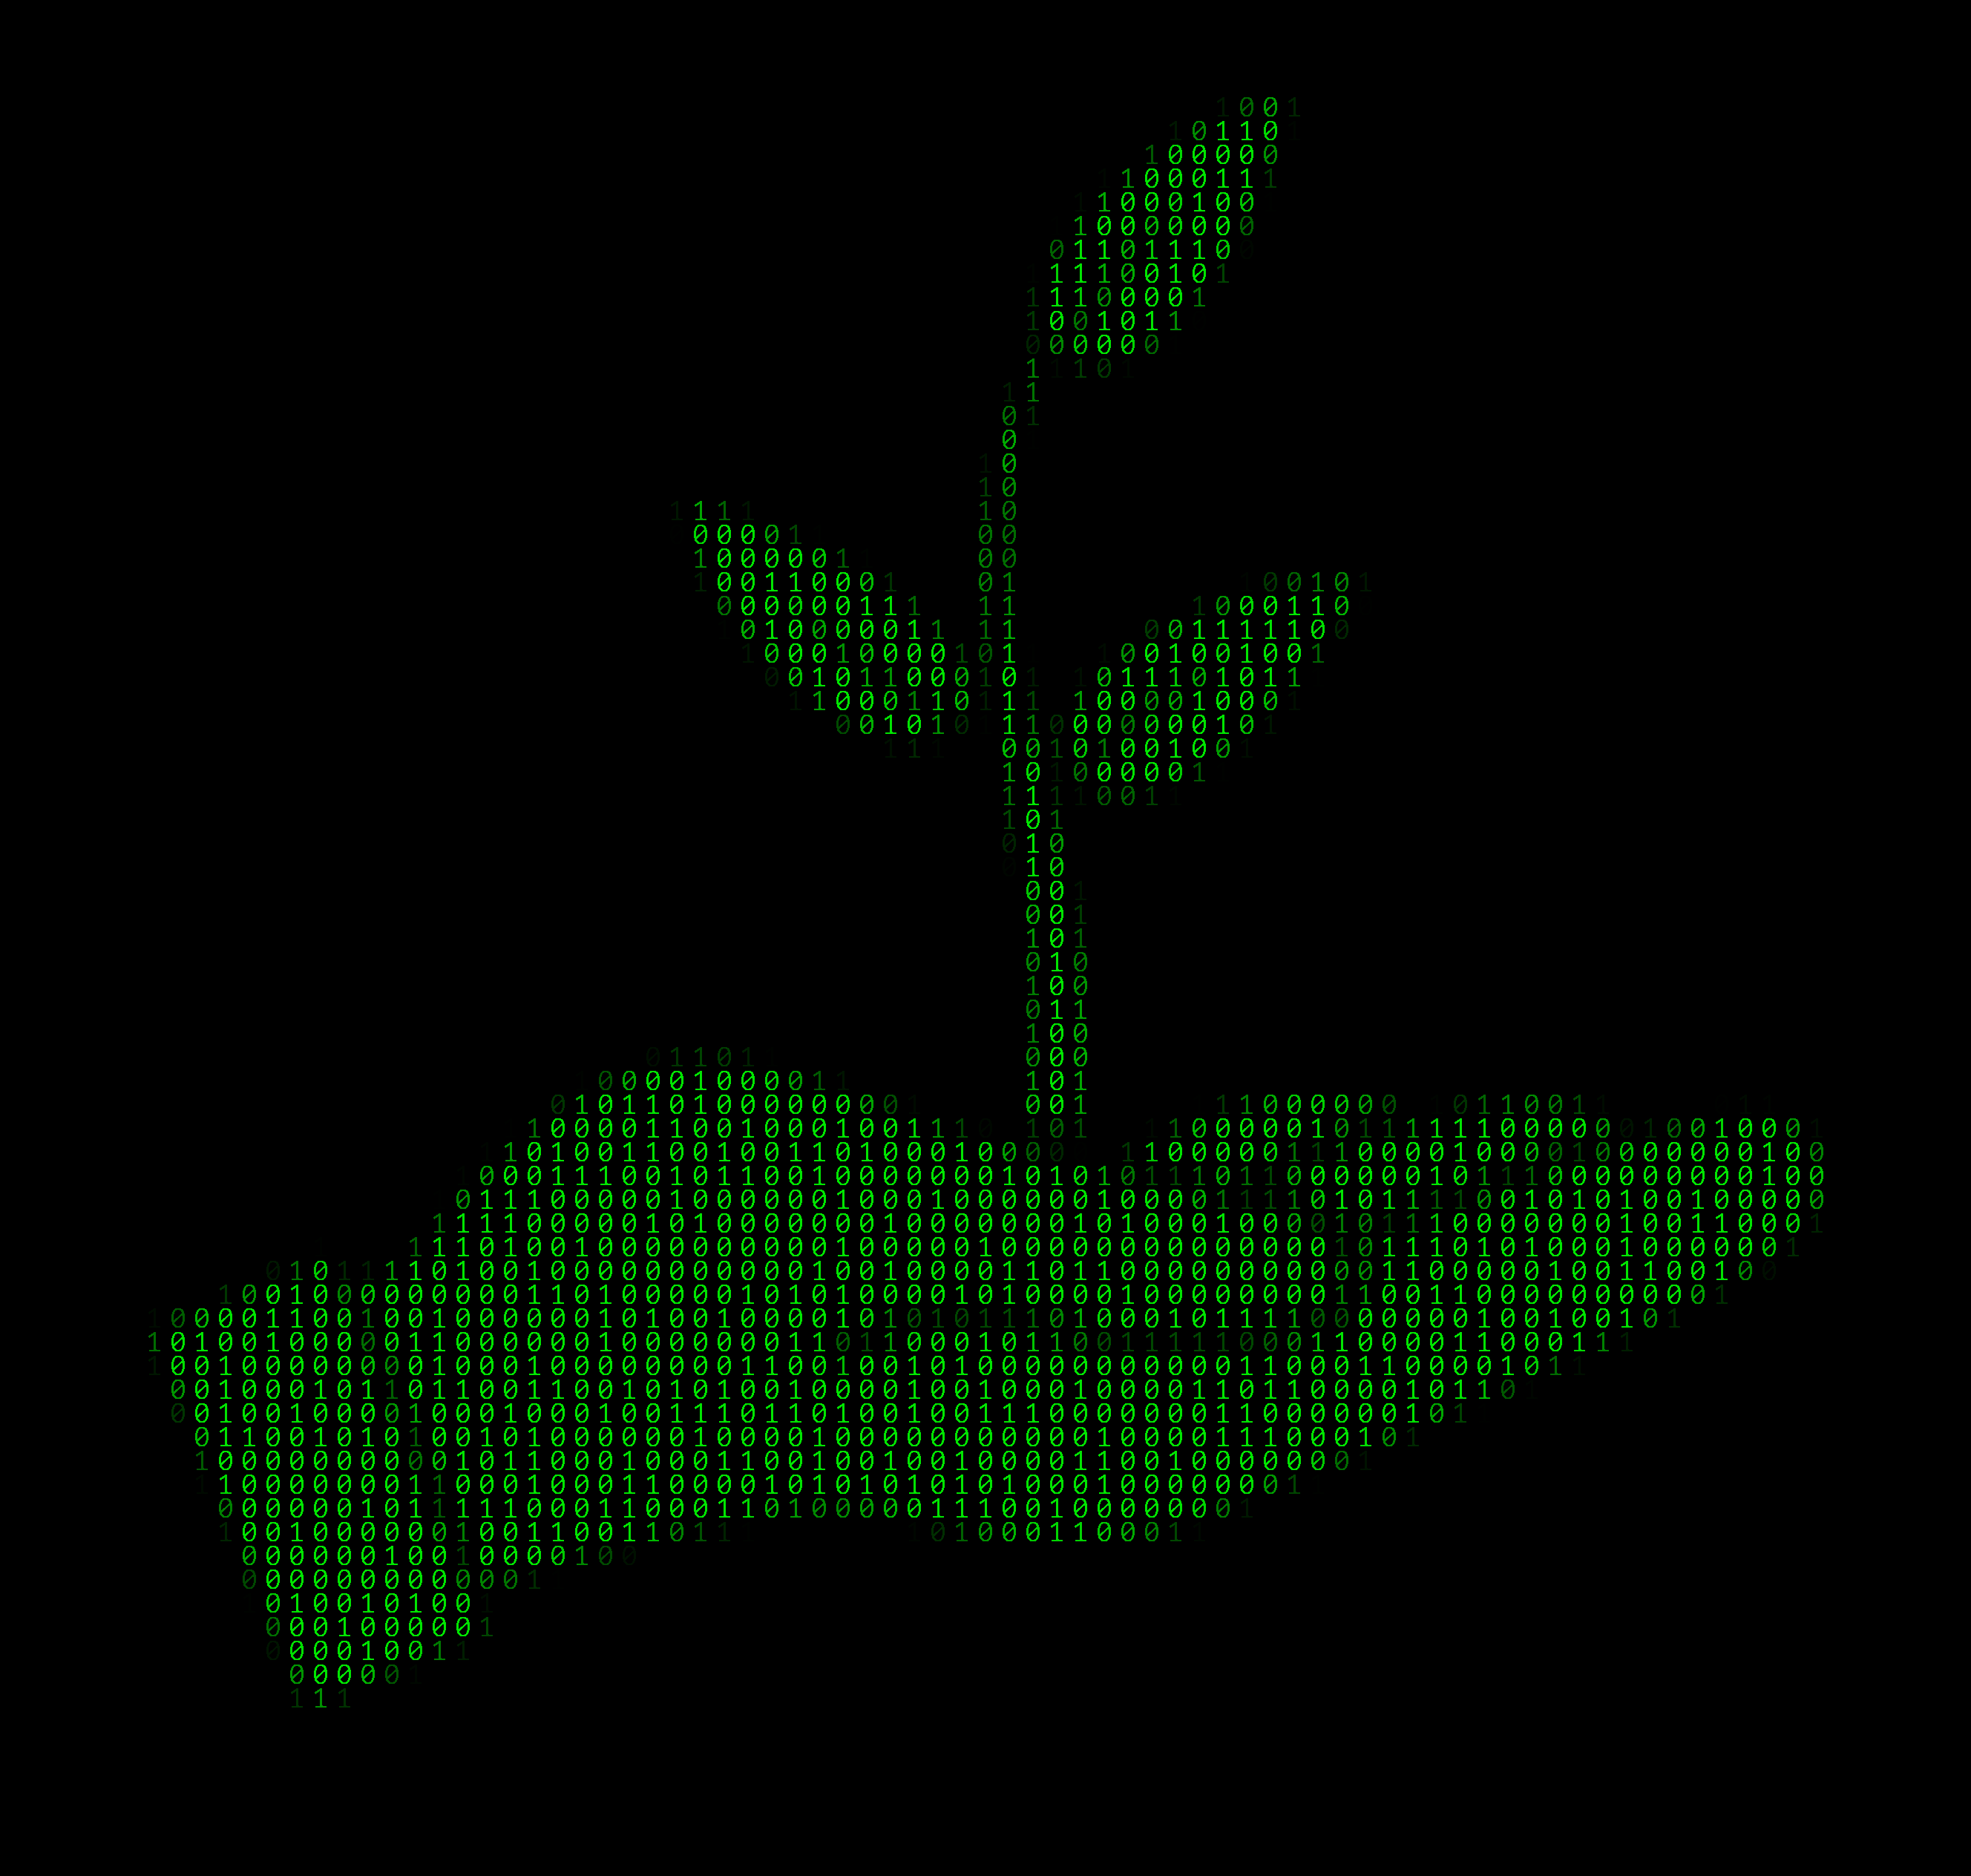

In [88]:
im1, im2 = binarize_image(src_path = './src/plant1.png', 
                          dst_w = 83,
                          px_per_block = 32,
                          alpha_dark = True,
                          invert_img = False,
                          background_color = (0,0,0),
                          im_color = (0,255,0))
Image.fromarray(im2)

In [ ]:
im1, im2 = binarize_image(src_path = './src/plant0.png', 
                          dst_w = 83,
                          px_per_block = 64,
                          alpha_dark = True,
                          invert_img = False,
                          background_color = (0,0,0),
                          im_color = (0,255,0))


In [70]:
im1, im2 = binarize_image(src_path = './src/hatt.png', 
                          dst_w = 23,
                          px_per_block = 64,
                          alpha_dark = True,
                          invert_img = False,
                          background_color = (0,0,0),
                          im_color = (0,255,0))

In [71]:
h,w = im1.shape[:2]

In [72]:
h,w

(1536, 1472)

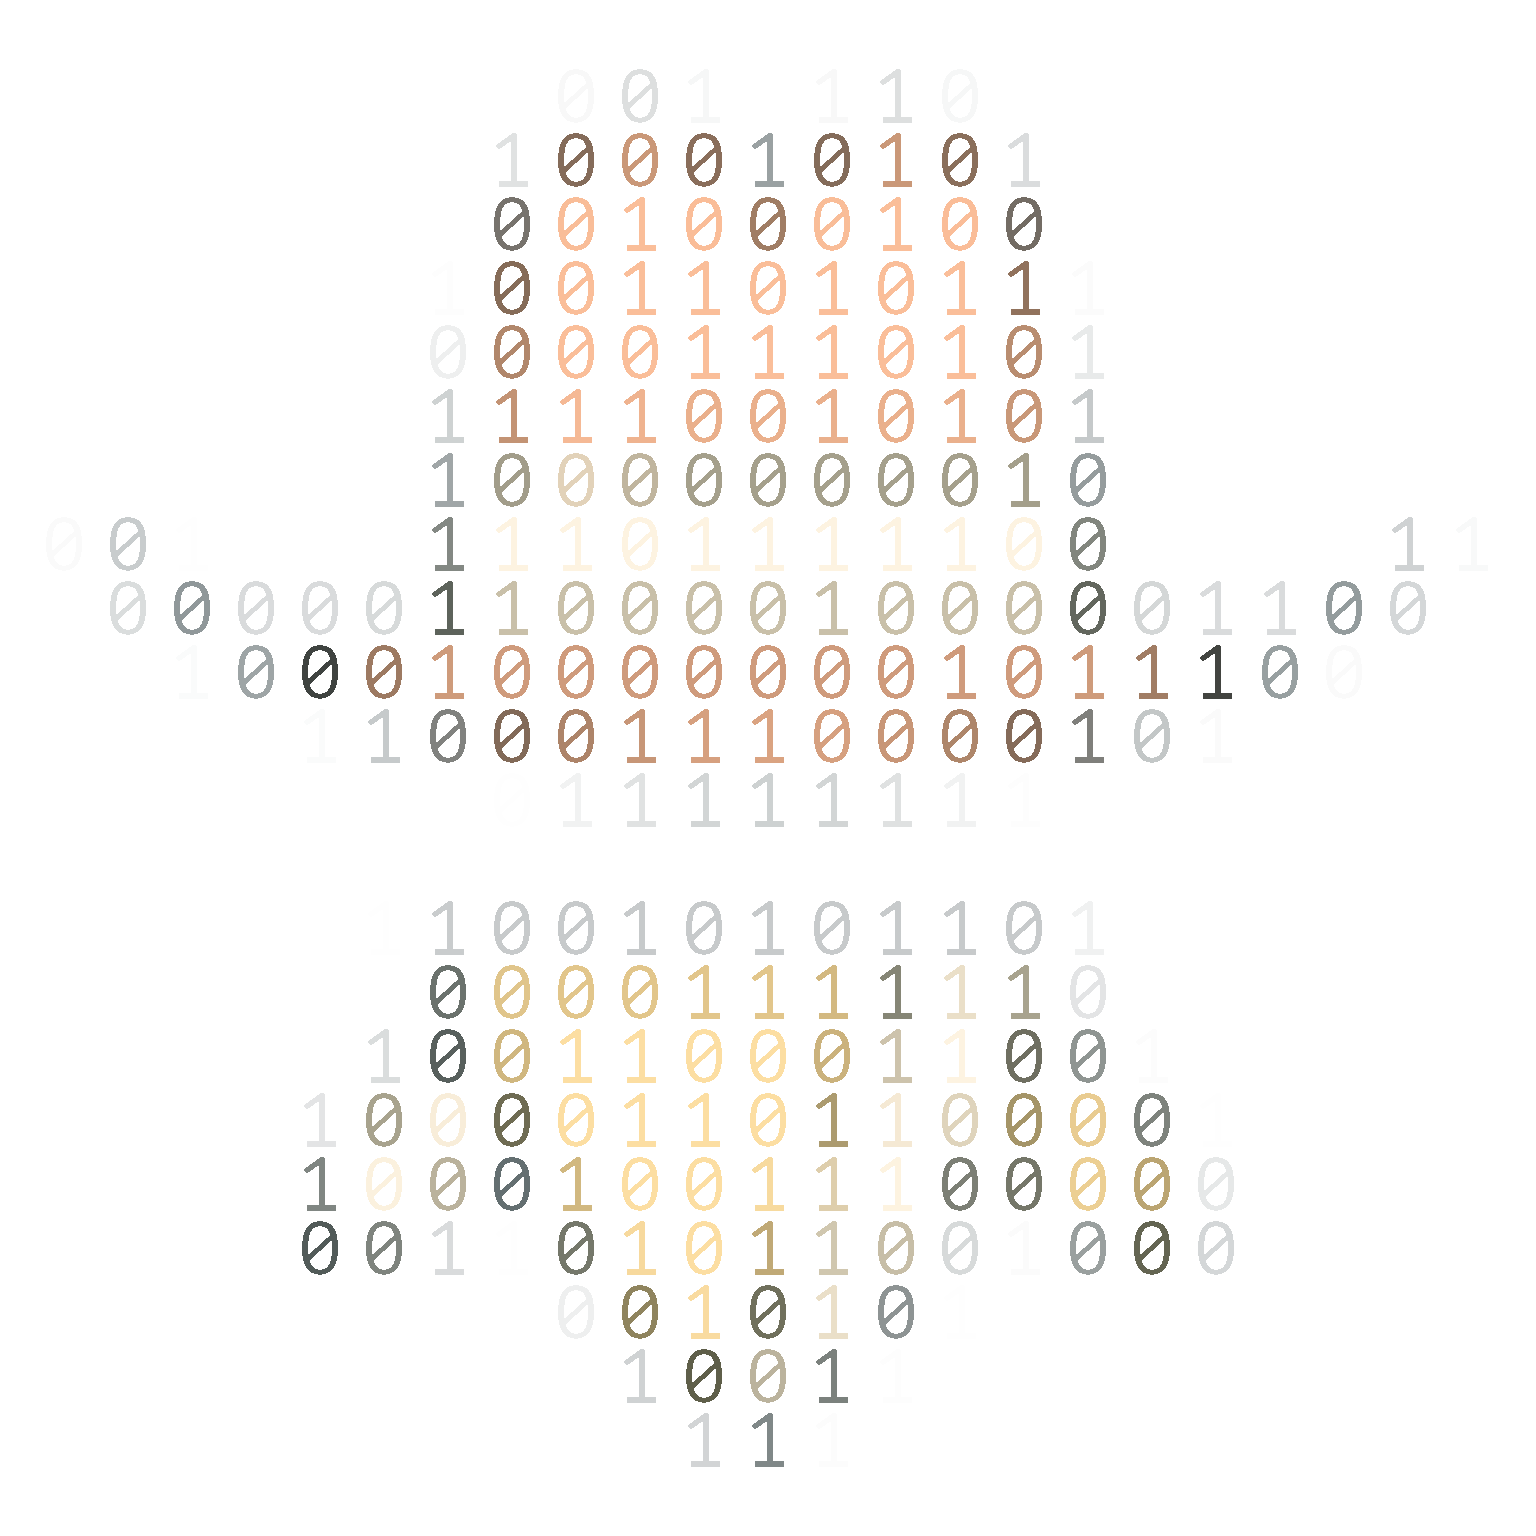

In [73]:
# increase width to make rectangular
im1 = cv2.copyMakeBorder(im1, 0, 0, (h-w)//2, (h-w)//2, cv2.BORDER_REPLICATE)
Image.fromarray(im1)

In [74]:
Image.fromarray(im1).save('./dst/favicon.ico', sizes=[(16, 16), (24, 24), (32, 32), (48, 48), (64, 64), (128, 128), (255, 255)])
Image.fromarray(im1).save('./dst/icon.png')


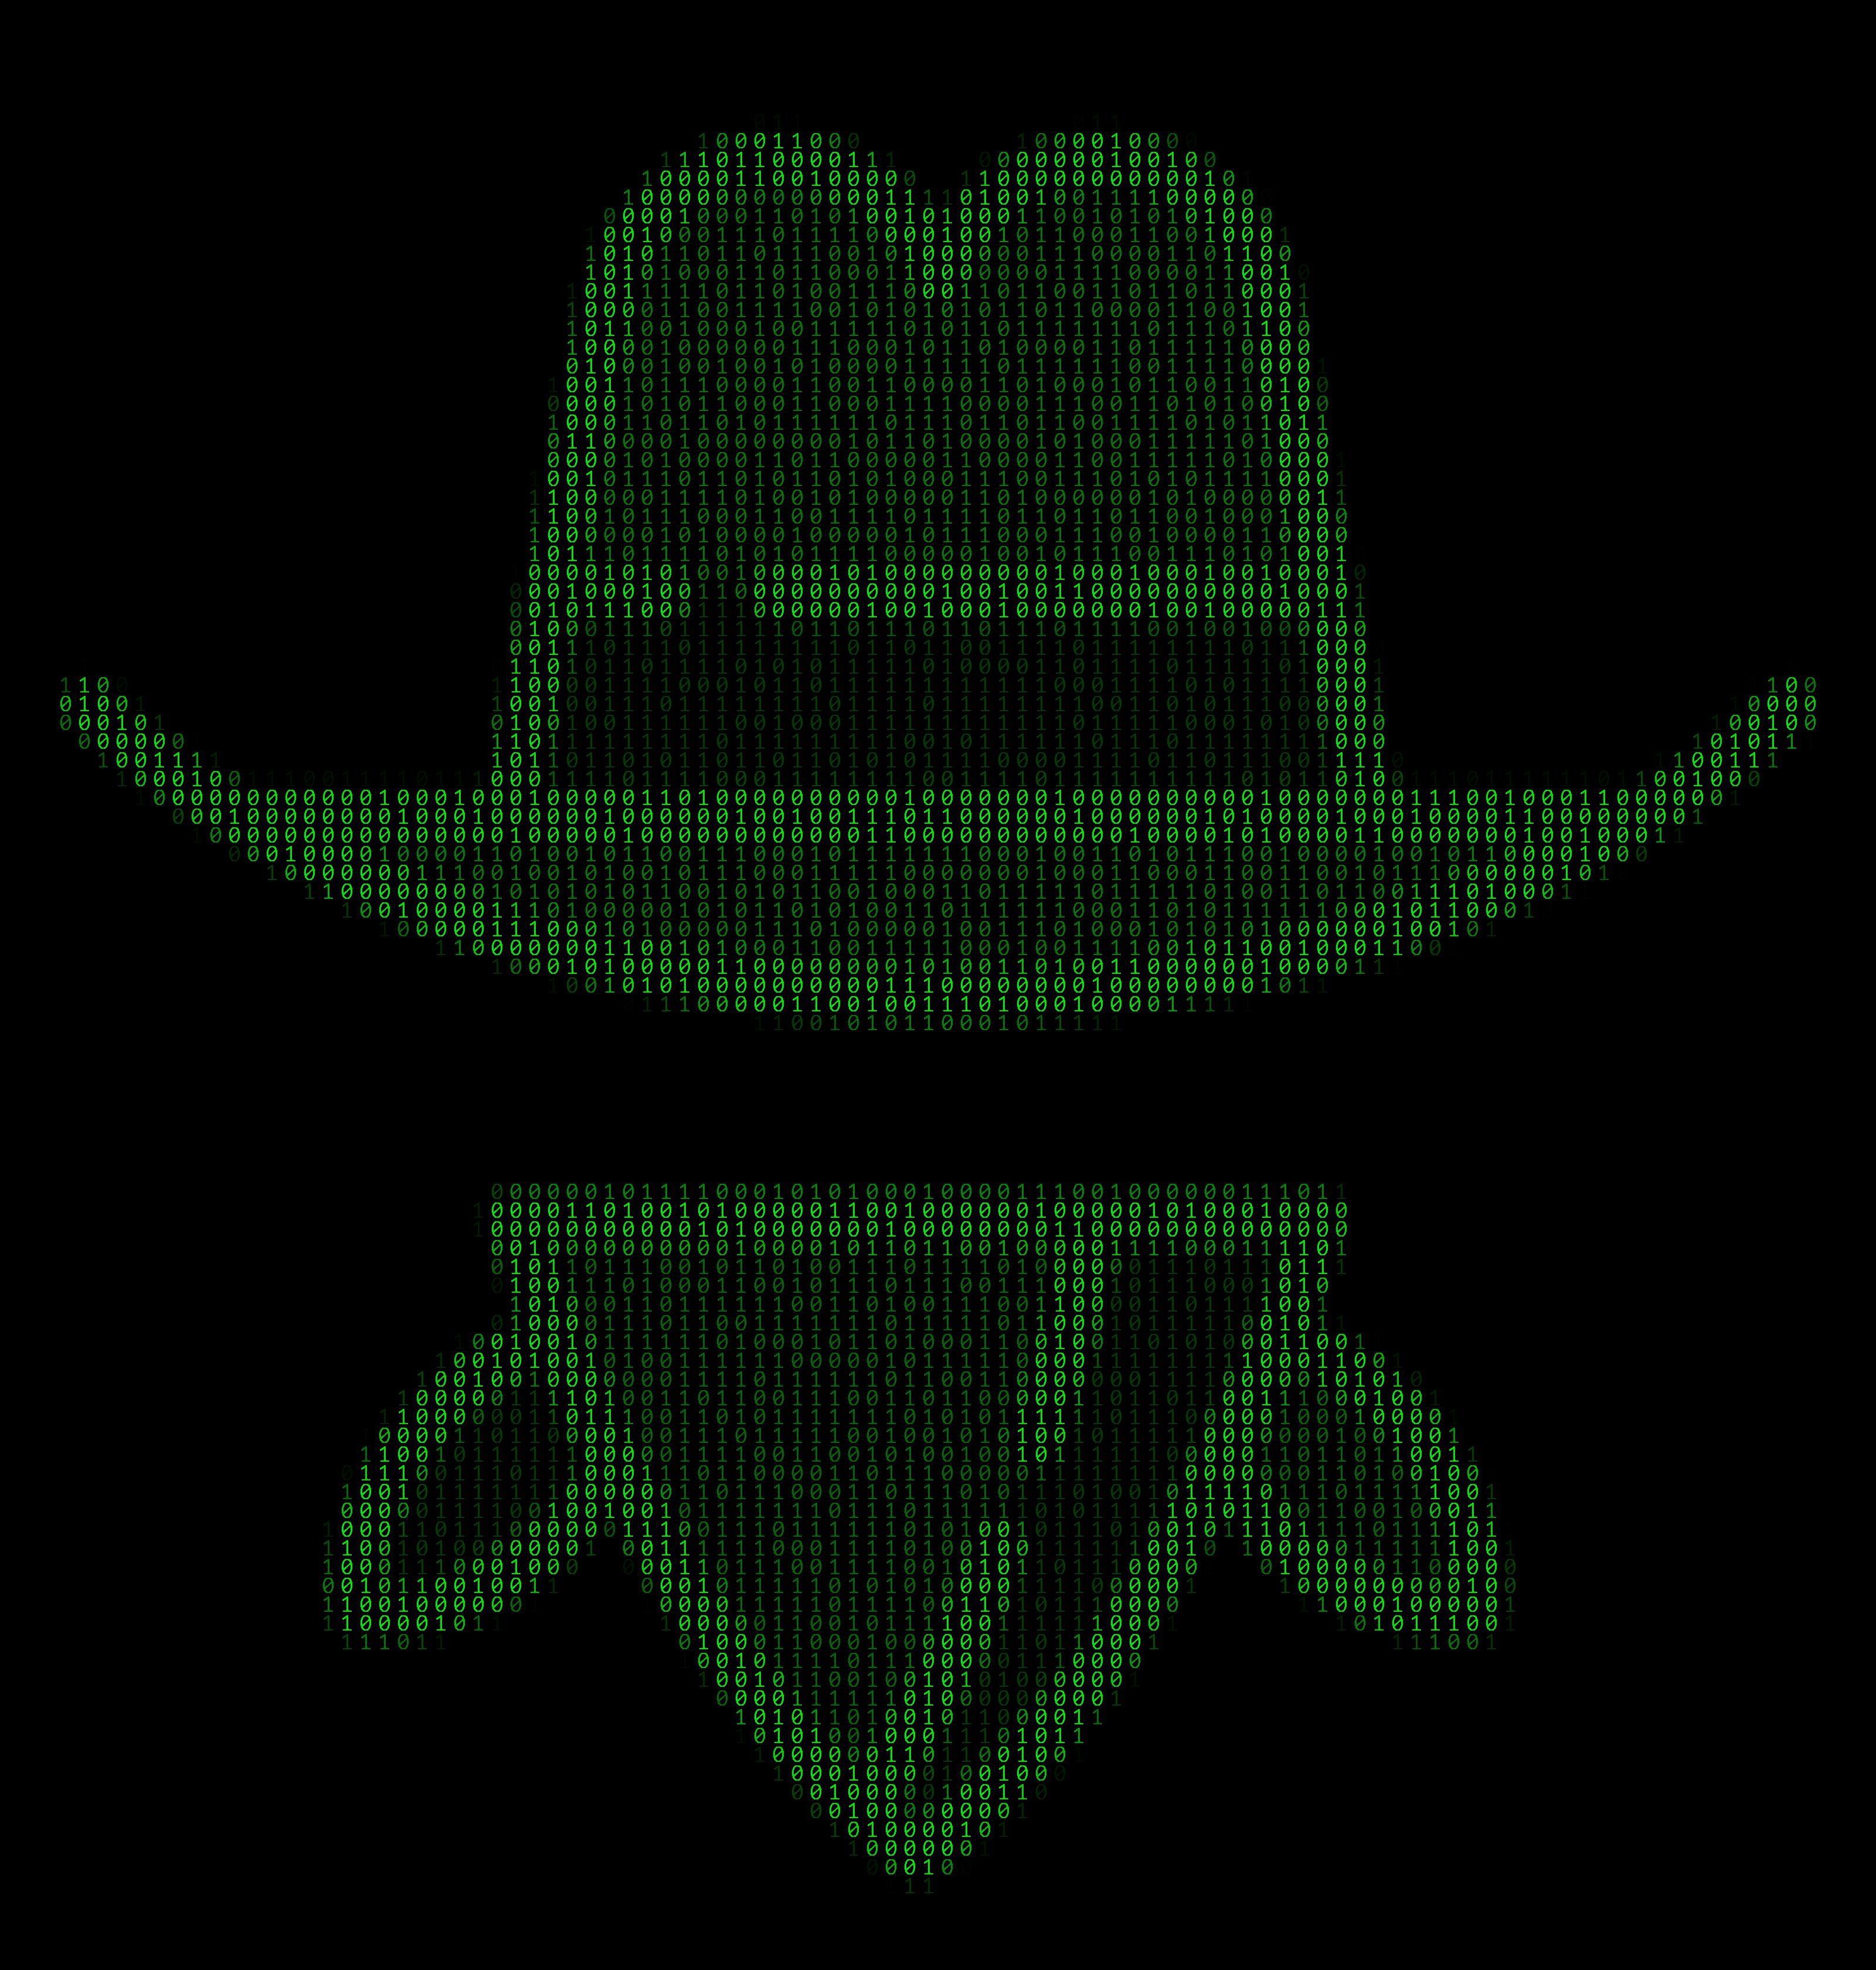

In [75]:
im11, im12 = binarize_image(src_path = './src/hatt.png', 
                          dst_w = 100,
                          px_per_block = 32,
                          alpha_dark = True,
                          invert_img = False,
                          background_color = (0,0,0),
                          im_color = (0,255,0))
Image.fromarray(im12)

In [77]:
Image.fromarray(im12).save('./dst/sym_large_matrix.png')
Image.fromarray(im11).save('./dst/sym_large.png')


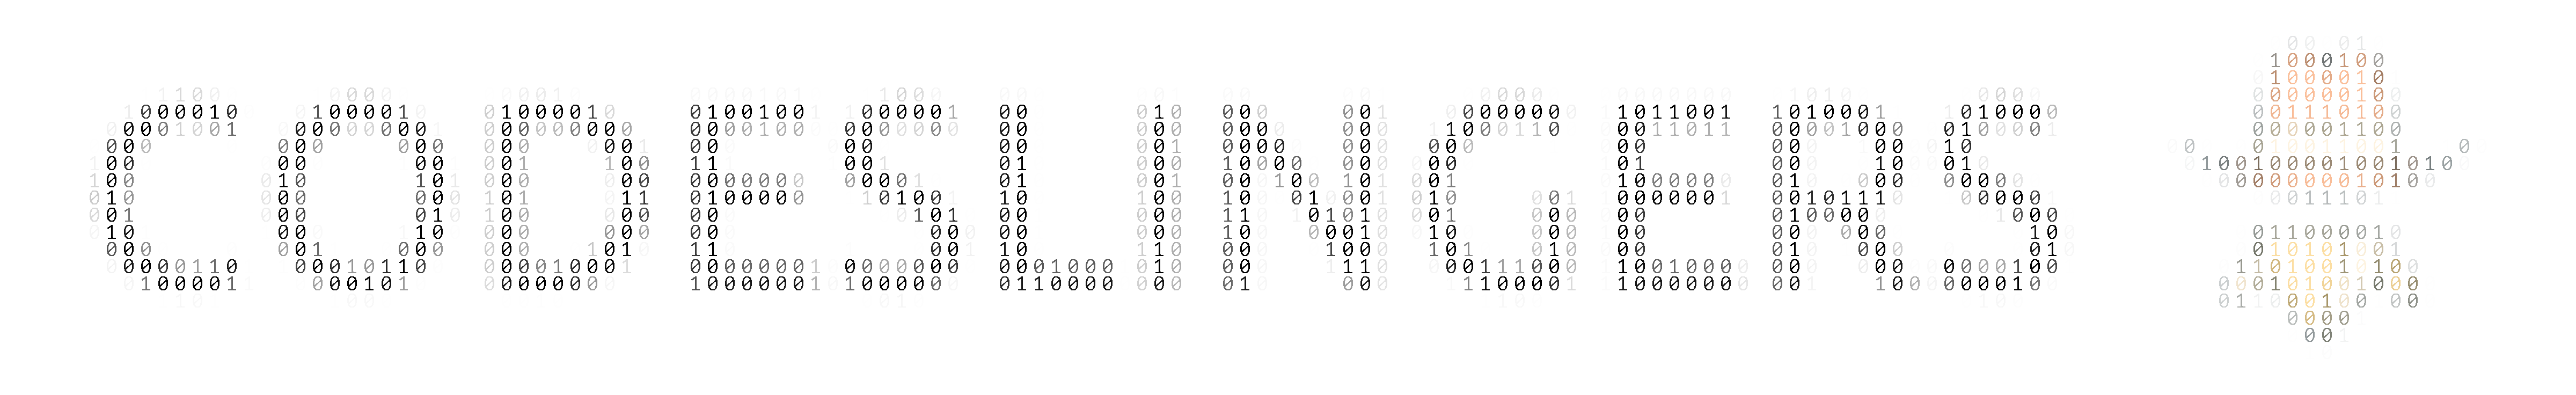

In [80]:
im1, im2 = binarize_image(src_path = './src/codeslingers_1.png', 
                          dst_w = 150,
                          px_per_block = 32,
                          alpha_dark = True,
                          invert_img = False,
                          to_gray = False,
                          pf=0.3,
                          background_color = (0,0,0),
                          im_color = (0,255,0))
Image.fromarray(im1)


In [34]:
im1.shape[0]/32

23.0

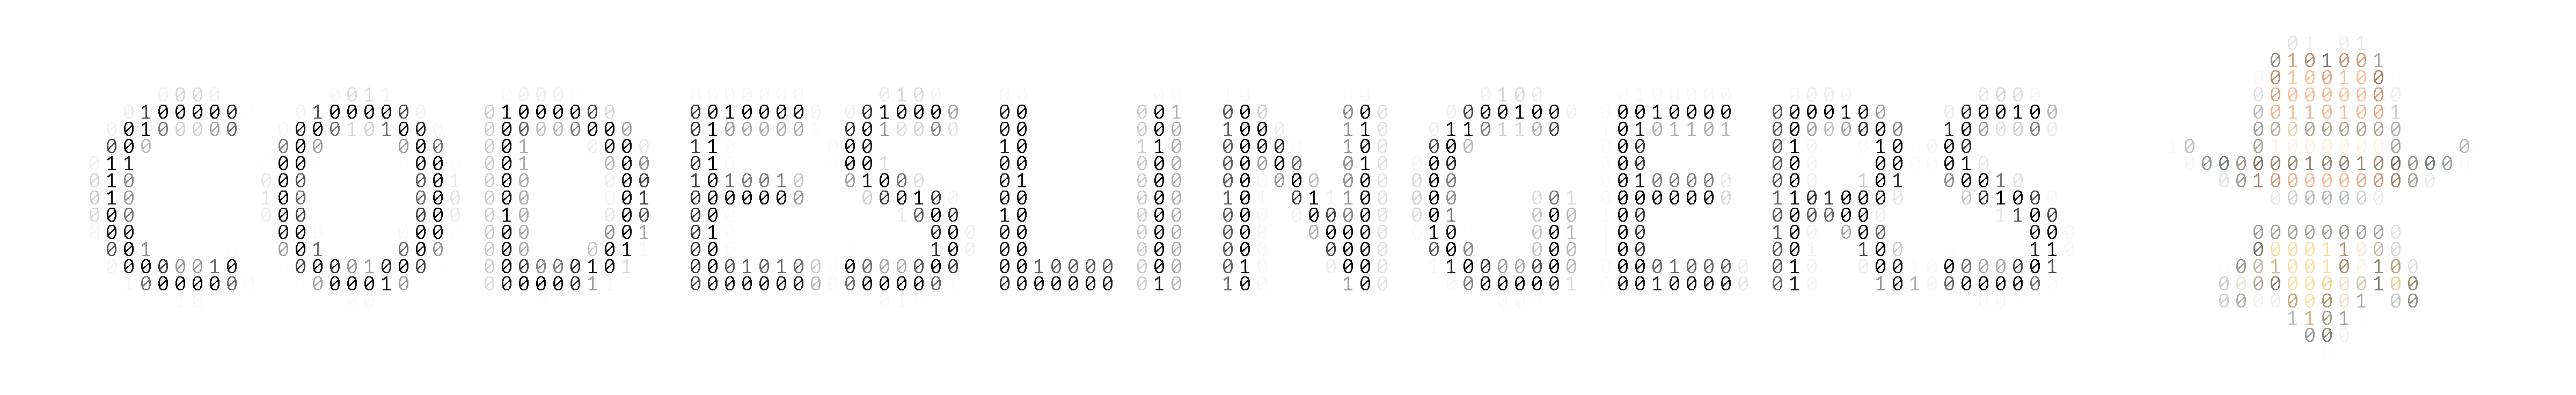

In [31]:
i1 = Image.fromarray(im1)
i1

In [32]:
Image.fromarray(im1).save('./dst/codeslingers_logo_small.png')
Image.fromarray(im2).save('./dst/codeslingers_logo_small_matrix.png')